<a href="https://colab.research.google.com/github/ayportella/curso_8_cloud/blob/main/modulo_44_cloud_native_data__pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
#**Projeto Pipeline de Dados do Telegram**

[Andressa Yumi Portella](https://www.linkedin.com/in/andressa-yumi-portella/)<br>
Maio de 2023


---

# **Tópicos**

<ol type="1">
  <li>Ingestão;</li>
  <li>ETL;</li>
  <li>Apresentação;</li>
  <li>Storytelling.</li>
</ol>

---

## 0\. Contexto

Este projeto corresponde à **implementação de um chatbot**, uma interface que permite usuários a interagir com uma aplicação de chat. Geralmente aparece como uma janela ou um pop-up em um website que inclui um campo em que é possível digitar as mensagens e um botão para que se inicie o chat com um chatbot em inteligência artificial ou com uma pessoa.<br>
Haverá a criação de uma **arquitetura de um datalake** a partir de dados gerados no Telegram em um chatbot, que será usado como um grande database para geração de métricas e entendimento de performance de uma campanha hipotética de um produto. Para isso, será gerado um **pipeline de dados** que permita a ingestão, processamento, armazenamento e exposição dessas mensagens, que serão usadas para análise posterior.<br>
Existe uma diferença em inteligência de marketing entre dados analíticos e transacionais. Os dados transacionais são informações capturadas em transações.
Já os dados analíticos surgem por meio de cálculos, ou análises executadas nos dados transacionais.


*   **Arquitetura:**

    *   **Sistema Transacional:** parte da arquitetura que ocorre no Telegram, na qual os dados serão produzidos. As mensagens geradas por usuários no grupo do Telegram são capturadas por um bot e redirecionadas para o AWS;<br> 
    *   **Sistema Analítico:** parte da arquitetura que ocorre no Amazon Web Services, na qual os dados serão analisados.
    

*   **Análise Exploratória de Dados:**

    *   **Fonte:** analisar o dado como ele é produzido pela API de bots do telegram através do uso do método getUpdates;<br>
    *   **Destino:** analisar o dado na etapa de apresentação com consultas sql e potenciais visualizações sobre os dados retornados.


Essa é uma imagem representativa do pipeline desse projeto:


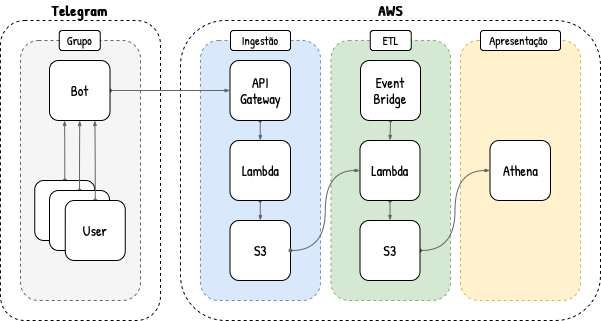

 - **Telegram**

Os usuários mandam mensagens no bot do Telegram, e a partir daí começa a etapa de ingestão do projeto, via webhook do backend do aplicativo para um endpoint (endereço web que aceita requisições HTTP) exposto pelo AWS API Gateway. As mensagens trafegam no corpo ou payload da requisição.



In [ ]:
# alocando o token de autenticação do botfather para acessar as mensagens via API
from getpass import getpass

token = getpass()

··········


A `url` base é comum a todos os métodos da API.

In [ ]:
# definindo url base 
import json

base_url = f'https://api.telegram.org/bot{token}'

In [ ]:
# metodo getMe retorna informações sobre o bot
import requests

response = requests.get(url=f'{base_url}/getMe')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": {
    "id": 6123914640,
    "is_bot": true,
    "first_name": "m43_ebac_yumi_bot",
    "username": "m43_ebac_yumi_bot",
    "can_join_groups": false,
    "can_read_all_group_messages": false,
    "supports_inline_queries": false
  }
}


 - **getUpdates**

O método `getMe` retorna as mensagens captadas pelo *bot*.

In [ ]:
# método getMe retorna as mensagens captadas pelo bot (sim, tem mensagem motivacional também rs)
response = requests.get(url=f'{base_url}/getUpdates')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": [
    {
      "update_id": 549939786,
      "message": {
        "message_id": 4,
        "from": {
          "id": 1079767099,
          "is_bot": false,
          "first_name": "Andressa",
          "username": "ayportella",
          "language_code": "en"
        },
        "chat": {
          "id": 1079767099,
          "first_name": "Andressa",
          "username": "ayportella",
          "type": "private"
        },
        "date": 1683761709,
        "text": "ol\u00e1"
      }
    },
    {
      "update_id": 549939787,
      "message": {
        "message_id": 3,
        "from": {
          "id": 1079767099,
          "is_bot": false,
          "first_name": "Andressa",
          "username": "ayportella",
          "language_code": "en"
        },
        "chat": {
          "id": -1001956165588,
          "title": "m43_ebac_bot_group",
          "type": "supergroup"
        },
        "date": 1683761777,
        "text": "olaaaaaaa"
      }
    },
   

## 1\. Ingestão

Aqui iremos fazer a etapa de ingestão dos dados transacionais (que foram gerados na etapa anterior) no ambiente analítico (nesse caso no AWS).

Serão criados um bucket no `AWS S3`, uma função no `AWS Lambda`, uma API web no `AWS API Gateway`, além de configuração de webhook da API de bots do Telegram.

A função abaixo `lambda_hadler` adicionada ao `AWS Lambda` recebe a mensagem captada no grupo do Telegram e a persiste no formato `JSON` no bucket no `AWS S3`, retornando uma mensagem de sucesso ou falha.


In [ ]:
import os
import json
import logging
from datetime import datetime, timezone, timedelta

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve, 
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')
  
  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

ModuleNotFoundError: ignored

Na etapa de **ingestão**, o `AWS API Gateway` tem a função de receber as mensagens captadas pelo *bot* do **Telegram**, enviadas via *webhook*, e iniciar uma função do `AWS Lambda`, passando o conteúdo da mensagem no seu parâmetro *event*. Para tanto vamos criar uma API e configurá-la como gatilho da função do `AWS Lambda`:

In [ ]:
aws_api_gateway_url = getpass()

··········


In [ ]:
# configurando o webhook para redirecionar as mensagens para a url do aws api gateway
response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": true,
  "description": "Webhook was set"
}


In [ ]:
# informações sobre o webhook configurado
response = requests.get(url=f'{base_url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": {
    "url": "https://c4i7r7n9hj.execute-api.sa-east-1.amazonaws.com/dev",
    "has_custom_certificate": false,
    "pending_update_count": 0,
    "max_connections": 40,
    "ip_address": "18.229.81.198"
  }
}


In [ ]:
curl -F "url=" https://api.telegram.org/bot<token>/setWebhook

## 2\. ETL

A etapa de **extração, transformação e carregamento** (do inglês *extraction, transformation and load* ou **ETL**) é uma etapa abrangente responsável pela manipulação dos dados ingeridos de sistemas transacionais, ou seja, já persistidos em camadas cruas ou *raw* de sistemas analíticos. Os processos conduzidos nesta etapa variam bastante de acordo com a área da empresa, do volume/variedade/velocidade do dado consumido, etc. Contudo, em geral, o dado cru ingerido passa por um processo recorrente de *data wrangling* onde o dado é limpo, deduplicado, etc. e persistido com técnicas de particionamento, orientação a coluna e compressão. Por fim, o dado processado está pronto para ser analisado por profissionais de dados.

No projeto, as mensagens de um único dia, persistidas na camada cru, serão compactas em um único arquivo, orientado a coluna e comprimido, que será persistido em uma camada enriquecida. Além disso, durante este processo, o dado também passará por etapas de *data wrangling*.

Para isso, vamos utilizar uma função do `AWS Lambda` como motor de processamento e um *bucket* do `AWS S3` como camada enriquecida para a persistência do dado processado. Para garantir a recorrência, vamos configurar uma regra do `AWS Event Bridge` como gatilho diáro da função.

### **2.1. AWS S3** 

Na etapa de **ETL**, o `AWS S3` tem a função de passivamente armazenar as mensagens processadas de um dia em um único arquivo no formato Parquet. Para tanto, basta a criação de um *bucket*. Como padrão, vamos adicionar o sufixo `-enriched` ao seu nome (vamos seguir esse padrão para todos os serviços desta camada).

> **Nota**: um `data lake` é o nome dado a um repositório de um grande volume dados. É organizado em zonas que armazenam replicadas dos dados em diferentes níveis de processamento. A nomenclatura das zonas varia, contudo, as mais comuns são: *raw* e *enriched* ou *bronze*, *silver* e *gold*.

### **2.2. AWS Lambda** 

Na etapa de **ETL**, o `AWS Lambda` tem a função de ativamente processar as mensagens captadas pelo *bot* do **Telegram**, persistidas na camada cru no *bucket* do `AWS S3`, e persisti-las na camada enriquecida, também em um *bucket* do `AWS S3`. Logo, vamos criar uma função que opera da seguinte forma:

 - Lista todos os arquivos JSON de uma única participação da camada crua de um *bucket* do `AWS S3`;
 - Para cada arquivo listado:
  - Faz o *download* do arquivo e carrega o conteúdo da mensagem;
  - Executa uma função de *data wrangling*;
  - Cria uma tabela do PyArrow e a contatena com as demais.
 - Persiste a tabela no formato Parquet na camada enriquecida em um *bucket* do `AWS S3`.

> **Nota**: O fato de utilizarmos duas camadas de armazenamento e processamento, permite que possamos reprocessar os dados crus de diversas maneiras, quantas vezes forem preciso.

> **Nota**: Atente-se ao fato de que a função processa as mensagens do dia anterior (D-1).

O código da função:

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único 
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None
          
      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True
  
  except Exception as exc:
      logging.error(msg=exc)
      return False

O código da função de *data wrangling*:

In [ ]:
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

## 3\. Apresentação

A etapa de **apresentação** é reponsável por entregar o dado para os usuários (analistas, cientistas, etc.) e sistemas (dashboards, motores de consultas, etc.), idealmente através de uma interface de fácil uso, como o SQL, logo, essa é a única etapa que a maioria dos usuários terá acesso. Além disso, é importante que as ferramentas da etapa entregem dados armazenados em camadas refinadas, pois assim as consultas são mais baratas e o dados mais consistentes.

### **3.1. AWS Athena** 

Na etapa de **apresentação**, o `AWS Athena` tem função de entregar o dados através de uma interface SQL para os usuários do sistema analítico. Para criar a interface, basta criar uma tabela externa sobre o dado armazenado na camada mais refinada da arquitetura, a camada enriquecida.

```sql
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint, 
  `user_id` bigint, 
  `user_is_bot` boolean, 
  `user_first_name` string, 
  `chat_id` bigint, 
  `chat_type` string, 
  `text` string, 
  `date` bigint)
PARTITIONED BY ( 
  `context_date` date)
ROW FORMAT SERDE 
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe' 
STORED AS INPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat' 
OUTPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://ayp-modulo-44-ebac-datalake-enriched/telegram/'
```

### **3.2. Analytics** 

Com o dado disponível, foram executadas diferentes consultas analíticas, exemplificadas a seguir:

- Quantidade total de mensagens por usuário

```sql
SELECT
    user_first_name,
    COUNT(message_id) AS "message_amount"
FROM telegram_v2
GROUP BY user_first_name;
```

  

**Resultado**




  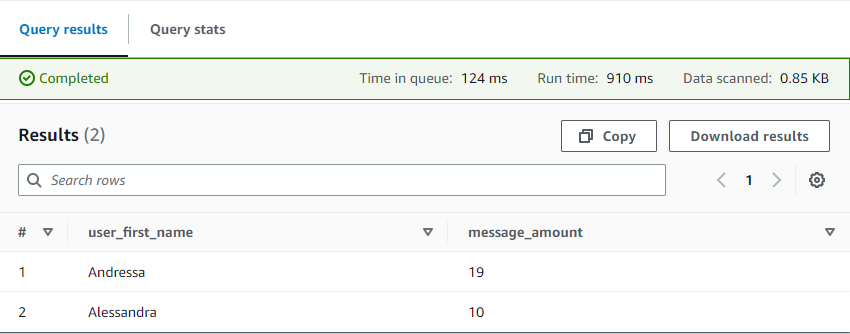
 

In [ ]:
import seaborn as sns
import pandas as pd
mensagens_dia = pd.read_csv("number_messages_user.csv")
mensagens_dia.head()
grafico = []

with sns.axes_style(style='whitegrid'):

  grafico = sns.barplot(x=mensagens_dia["user_first_name"], y=mensagens_dia["message_amount"])
  grafico.set(title='Total de Mensagens Enviadas por Usuário', xlabel='Usuário', ylabel='Quantidade de Mensagens')
  sns.set(rc = {'figure.figsize':(10,6)})

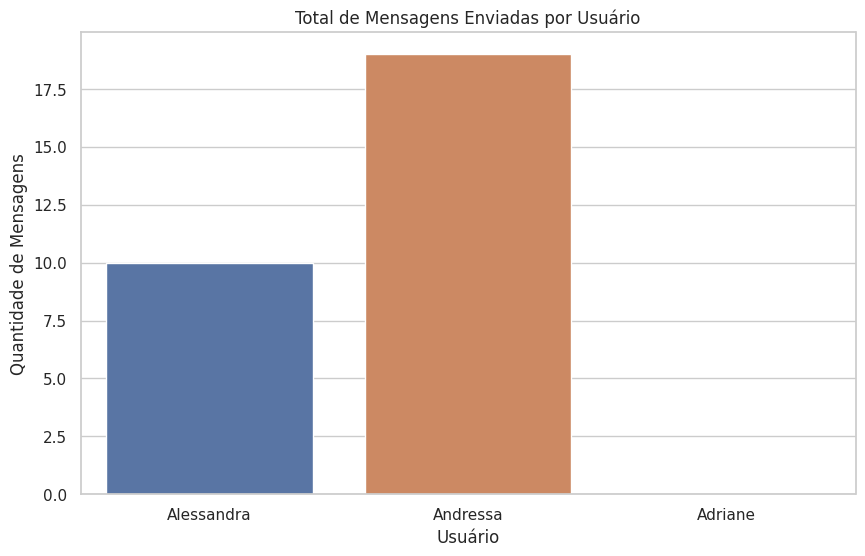

A partir dessa consulta, pode-se perceber quais usuários estão ativos e quais não interagem com o grupo, e analisar outras formas de engajamento entre os usuários que não se mostraram interessados ainda.

A usuária Andressa enviou 65,52% do total das mensagens enquanto que a usuária Alessandra enviou 34,48%.


- Quantidade de mensagens por dia

```sql
SELECT 
  context_date, 
  count(message_id) AS "message_amount" 
FROM "telegram_v2" 
GROUP BY context_date 
ORDER BY context_date DESC
```

**Resultado**

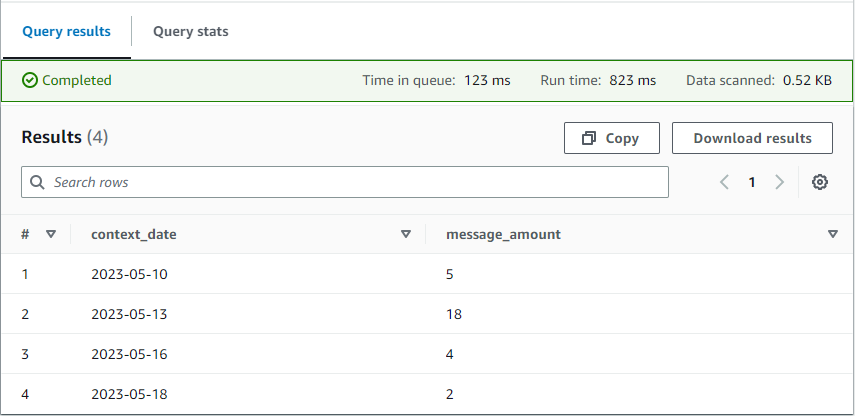



In [ ]:
mensagens_dia2 = pd.read_csv("messages_per_day.csv")

mensagens_dia2.head()
grafico2 = []

with sns.axes_style(style='whitegrid'):

  grafico2 = sns.lineplot(x=mensagens_dia2["context_date"], y=mensagens_dia2["message_amount"])
  grafico2.set(title='Quantidade de Mensagens por Dia', xlabel='Data', ylabel='Quantidade de Mensagens por dia')
  grafico2.set_xticklabels(
      labels=["18/05/2023","17/05/2023","16/05/2023","15/05/2023","14/05/2023","13/05/2023","12/05/2023","11/05/2023","10/05/2023"], rotation=30)
  sns.set(rc = {'figure.figsize':(10,6)})

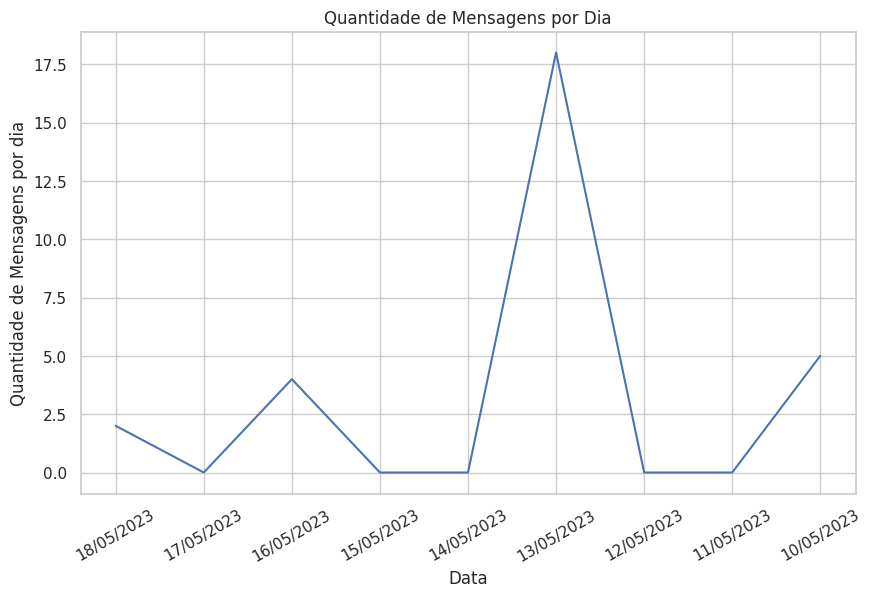

Houve maior interação entre os usuários nos dias 10, 13, 17 e 18 de maio. A que se deve essa interação? Podemos repetir esse evento criando gatilhos que gerem novamente maior interesse dos usuários? Essas são questões importantes a serem respondidas pelo modelo de negócio.

O dia 13 de maio chama bastante atenção, com um pico de mensagens bem acima dos outros dias. Seria interessante entender o que motivou esse interesse maior dos usuários no grupo e tentar replicar o evento ao longo do ano.

- Média do tamanho das mensagens por dia

```sql
SELECT 
  context_date,
  CAST(AVG(length(text)) AS INT) AS "average_message_length" 
FROM "telegram_v2" 
GROUP BY 
  context_date 
ORDER BY context_date DESC;
```

**Resultado**

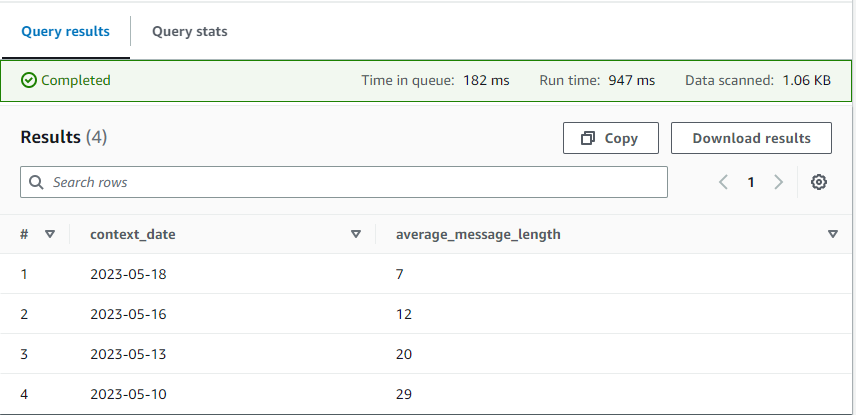


In [ ]:
mensagens_dia3 = pd.read_csv("media_tamanho_mensagens.csv")
mensagens_dia3.head()
grafico3 = []

mensagens_dia3.head()

with sns.axes_style(style='whitegrid'):

  grafico3 = sns.lineplot(x=mensagens_dia3["context_date"], y=mensagens_dia3["average_message_length"])
  grafico3.set(title='Média do Tamanho de Mensagens por Dia', xlabel='Data', ylabel='Média do Tamanho de Mensagens')
  grafico3.set_xticklabels(
      labels=["10/05/2023","11/05/2023","12/05/2023","13/05/2023","14/05/2023","15/05/2023","16/05/2023","17/05/2023","18/05/2023"], rotation=70)
  sns.set(rc = {'figure.figsize':(10,5)})

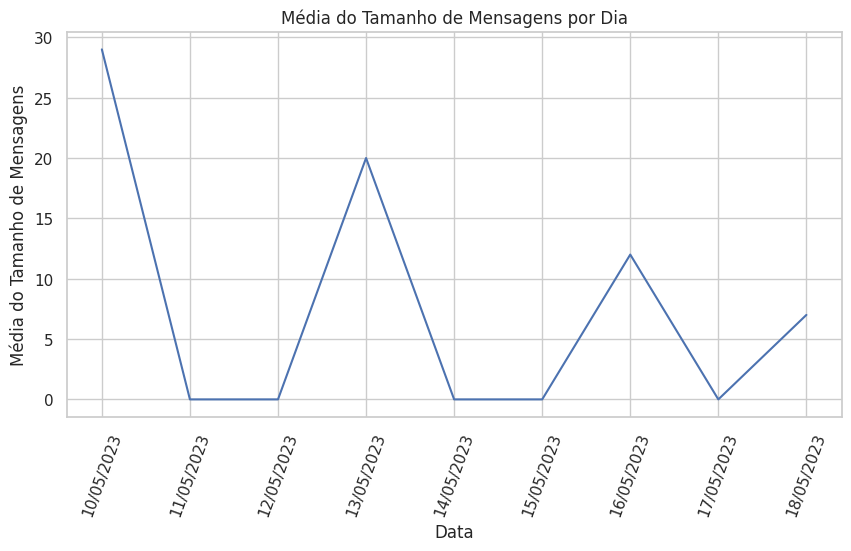

Houve um decréscimo progressivo entre a média do número de caracteres de mensagens de texto por dia, em ordem cronológica. Pode-se buscar entender porque a intenção de escrever mensagens maiores foi decrescendo ao longo do tempo e quais ações mitigadoras a esse evento podem ser feitas, de modo a ter usuários gastando mais tempo lendo e escrevendo mensagens maiores.

- Quantidade de mensagens por hora, por dia da semana e por número da semana

```sql
WITH 
parsed_date_cte AS (
    SELECT 
        *, 
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram_v2" 
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount" 
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday
```

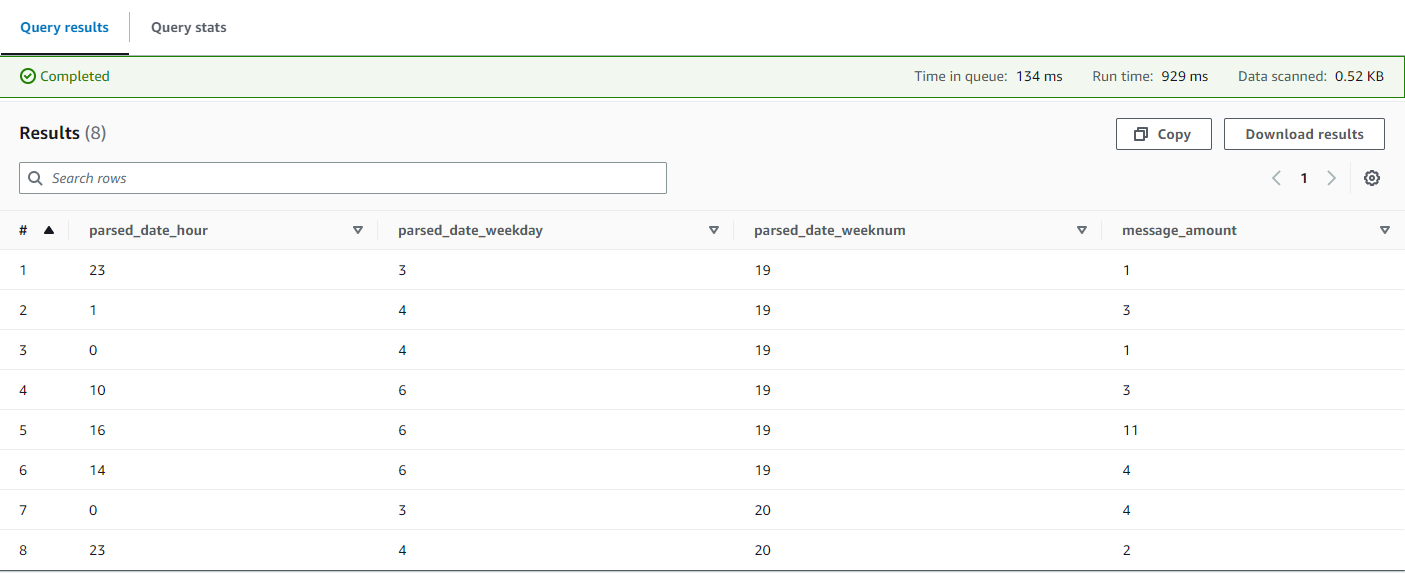


*   parsed_day_hour é bem intuitivo, com cada número representando as horas do dia variando de 0 a 23;
*   parsed_day_weekday são os dias da semana, variando de 1 a 7, com 1 representando segunda-feira e 7 domingo;
*   parsed_day_weeknum são as semanas do ano, com a primeira semana do ano representada por 1, e a última do ano por 53.



Pode-se tentar entender quais momentos os usuários estão mais dispostos a utilizar o chatbot, e assim prever em quais momentos poderá ter maior demanda de atenção da equipe em caso de vendas, por exemplo, ou lançamento de produto. 

# **Conclusão**

A instauração do pipeline foi efetiva para possibilitar a captação, a transformação e o carregamento das mensagens no grupo do Telegram na cadeia do AWS criada, permitindo consultas nos dados gerados a partir do AWS Athena. 

Empresas podem se beneficiar com o uso de chatbots e a análise dos dados gerados por ele, uma vez que facilitam a interação dos clientes com as mesmas, expondo produtos, facilitando a compra ou mesmo o processo de atendimento ao cliente no pós-compra. Os insights que podem ser extraídos pelo analista de dados ajudam na tomada de decisão a fim de implementar melhorias em futuros lançamentos de produtos, como melhores horários para isso por exemplo, o que pode ser ampliado de acordo com maior demanda do cliente, quais os perfis de quem mais interage e finaliza compras, entre outros. 